In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('train.csv')
check = pd.read_csv('sample_submission.csv')
data.head()

,Unnamed: 0,image_path,emotion
0,0,./train/anger/0.jpg,anger
1,1,./train/anger/1.jpg,anger
2,2,./train/anger/10.jpg,anger
3,3,./train/anger/100.jpg,anger
4,4,./train/anger/1000.jpg,anger


In [3]:
# Удаление индексного столбца
data = data.drop(columns=['Unnamed: 0'])

# Проверка распределения эмоций
emotion_distribution = data['emotion'].value_counts()
emotion_distribution

emotion
anger        7022
neutral      6795
sad          6740
surprise     6323
happy        5955
uncertain    5927
fear         5044
disgust      3155
contempt     3085
Name: count, dtype: int64

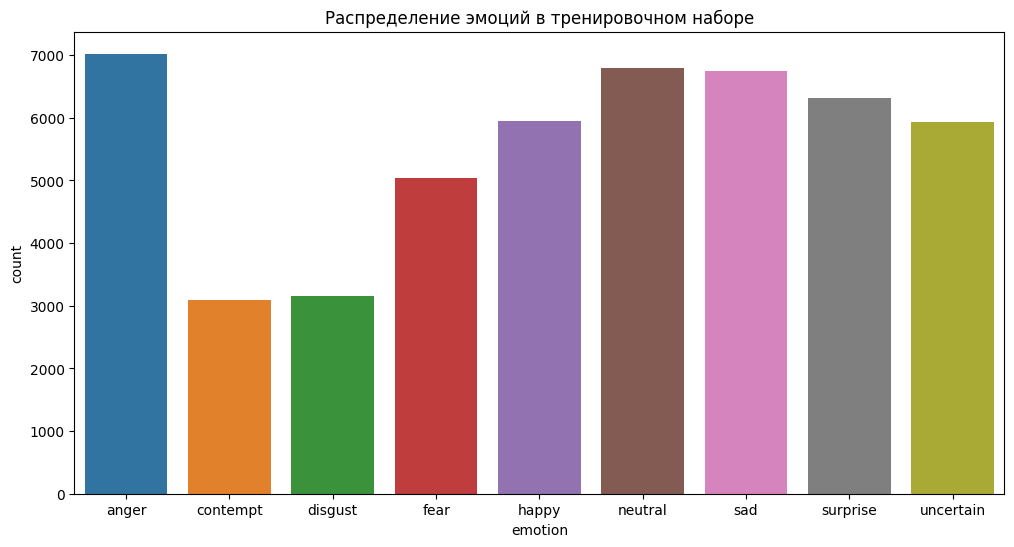

In [4]:
# Посмотрим на распределение эмоций
plt.figure(figsize=(12, 6))
sns.countplot(x='emotion', data=data)
plt.title('Распределение эмоций в тренировочном наборе')
plt.show()

# Обучение модели

In [5]:
# Проверка наличия файлов
missing_files = [path for path in data['image_path'] if not os.path.isfile(path)]
if missing_files:
    print(f"Отсутствуют файлы: {missing_files}")
else:
    print("Все файлы предоставлены")

Все файлы предоставлены


Found 40036 validated image filenames belonging to 9 classes.
Found 10010 validated image filenames belonging to 9 classes.


Epoch 1/50


1252/1252 [==============================] - 1065s 850ms/step - loss: 2.2033 - accuracy: 0.1336 - val_loss: 2.1616 - val_accuracy: 0.1735
Epoch 2/50


C:\Users\NeKonn\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1252/1252 [==============================] - 1064s 850ms/step - loss: 2.1678 - accuracy: 0.1568 - val_loss: 2.1072 - val_accuracy: 0.1920
Epoch 3/50
1252/1252 [==============================] - 1078s 861ms/step - loss: 2.1287 - accuracy: 0.1789 - val_loss: 2.0712 - val_accuracy: 0.2548
Epoch 4/50
1252/1252 [==============================] - 1140s 911ms/step - loss: 2.1160 - accuracy: 0.1876 - val_loss: 2.0469 - val_accuracy: 0.2514
Epoch 5/50
1252/1252 [==============================] - 1156s 923ms/step - loss: 2.0995 - accuracy: 0.1944 - val_loss: 2.0225 - val_accuracy: 0.2548
Epoch 6/50
1252/1252 [==============================] - 1155s 922ms/step - loss: 2.0936 - accuracy: 0.1957 - val_loss: 2.0481 - val_accuracy: 0.2525
Epoch 7/50
1252/1252 [==============================] - 1083s 865ms/step - loss: 2.0822 - accuracy: 0.2017 - val_loss: 1.9969 - val_accuracy: 0.2746
Epoch 8/50
1252/1252 [==============================] - 1073s 857ms/step - loss: 2.0703 - accuracy: 0.2076 - val_loss

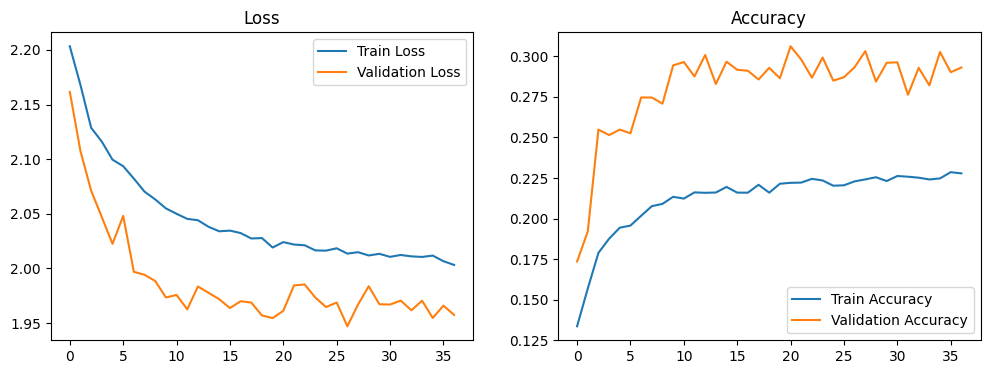

In [6]:
# Разделение данных на тренировочные и тестовые выборки
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['emotion'], random_state=42)

# Генераторы данных с аугментацией
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='emotion',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col='image_path',
    y_col='emotion',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Получение весов классов
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data['emotion']),
    y=train_data['emotion']
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Создание модели на основе VGG16 с fine-tuning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Заморозка базовой модели

# Добавление новых слоев
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')  # 9 классов эмоций
])

# Разморозка верхних слоев базовой модели
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Коллбеки для сохранения лучшей модели и ранней остановки
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Обучение модели
history = model.fit(train_generator, epochs=50, validation_data=test_generator, class_weight=class_weights,
                    callbacks=[checkpoint, early_stopping])

# Сохранение модели
model.save('emotion_classification_model.h5')

# Визуализация результатов
# График потерь
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

# График точности
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Предсказание на тестовых данных

In [7]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# Загрузка обученной модели
model = load_model('emotion_classification_model.h5')

# Подготовка тестовых данных
test_data_dir = 'test'  # Путь к папке с тестовыми изображениями
test_images = [os.path.join(test_data_dir, img) for img in os.listdir(test_data_dir) if img.endswith('.jpg')]

# Создание DataFrame для тестовых данных
test_df = pd.DataFrame(test_images, columns=['image_path'])

# Генератор данных для тестовых изображений
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col=None,
    target_size=(224, 224),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Предсказание эмоций
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Сопоставление индексов классов с их названиями
class_indices = train_generator.class_indices
labels = {v: k for k, v in class_indices.items()}
predicted_labels = [labels[k] for k in predicted_classes]

# Добавление предсказанных эмоций в DataFrame
test_df['emotion'] = predicted_labels

# Удаление пути к изображению, оставляем только имя файла
test_df['image_path'] = test_df['image_path'].apply(lambda x: os.path.basename(x))

# Сохранение результатов предсказаний в CSV файл
test_df.to_csv('predictions.csv', index=False)

# Вывод первых нескольких строк для проверки
print(test_df.head())

Found 5000 validated image filenames.
157/157 [==============================] - 110s 702ms/step
  image_path   emotion
0      0.jpg       sad
1      1.jpg  contempt
2     10.jpg     anger
3    100.jpg  contempt
4   1000.jpg     anger


In [10]:
test_df.head()

,image_path,emotion
0,0.jpg,sad
1,1.jpg,contempt
2,10.jpg,anger
3,100.jpg,contempt
4,1000.jpg,anger


# Создание скрипта для асессоров

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
# Загрузка данных
data = pd.read_csv('train.csv')
data = data.drop(columns=['Unnamed: 0'])

# Разделение данных на тренировочные и тестовые выборки
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['emotion'], random_state=42)

# Генераторы данных для загрузки изображений
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    x_col='image_path',
    y_col='emotion',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    x_col='image_path',
    y_col='emotion',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Создание модели на основе VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(9, activation='softmax')  # 9 классов эмоций
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

# Сам скрипт

In [ ]:
# Загрузка предобученной модели
model = load_model('model.h5')
emotion_labels = ['anger', 'neutral', 'sad', 'surprise', 'happy', 'uncertain', 'fear', 'disgust', 'contempt']

# Инициализация веб-камеры
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Преобразование кадра для модели
    face = cv2.resize(frame, (224, 224))
    face = img_to_array(face)
    face = np.expand_dims(face, axis=0) / 255.0

    # Предсказание эмоции
    preds = model.predict(face)[0]
    emotion = emotion_labels[np.argmax(preds)]

    # Отображение результата на экране
    cv2.putText(frame, emotion, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    cv2.imshow('Emotion Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()